## Reading the input file
### The input file is a large set of names taken from:
https://github.com/karpathy/makemore/blob/master/names.txt

In [253]:
words = open("names.txt", "r").read().splitlines()

In [254]:
print("First ten words in the dataset:")
print(words[:10])
print("\nAmount of words in the dataset")
print(len(words))

First ten words in the dataset:
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']

Amount of words in the dataset
32033


## Lets find the rate at which each letter follows another letter in the dataset

### Note: We will also find the rate of which a letter will be the start or end to a word

In [255]:
import torch

### For ease of use, we will make a 2D array to represent the word counts

In [498]:
countsArray = torch.zeros((27,27),dtype=torch.int32) + 1

In [499]:
#A list of all letters in the alphabet sorted from a-z
alphabet = sorted(list(set("".join(words))))

stoi = {s:i+1 for i,s in enumerate(alphabet)}
stoi["."] = 0 # a special character to indiciate the start or end of a word
itos = {i:s for s,i in stoi.items()}


In [500]:
for word in words:
    chs = ["."] + list(word) + ["."]
    for ch1, ch2 in zip(chs,chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        countsArray[ix1,ix2] += 1

In [501]:
import matplotlib.pyplot as plt

This figure represents the amount of times a specific two letter string is present in the input file.
The '.' character represents the start or end of a string


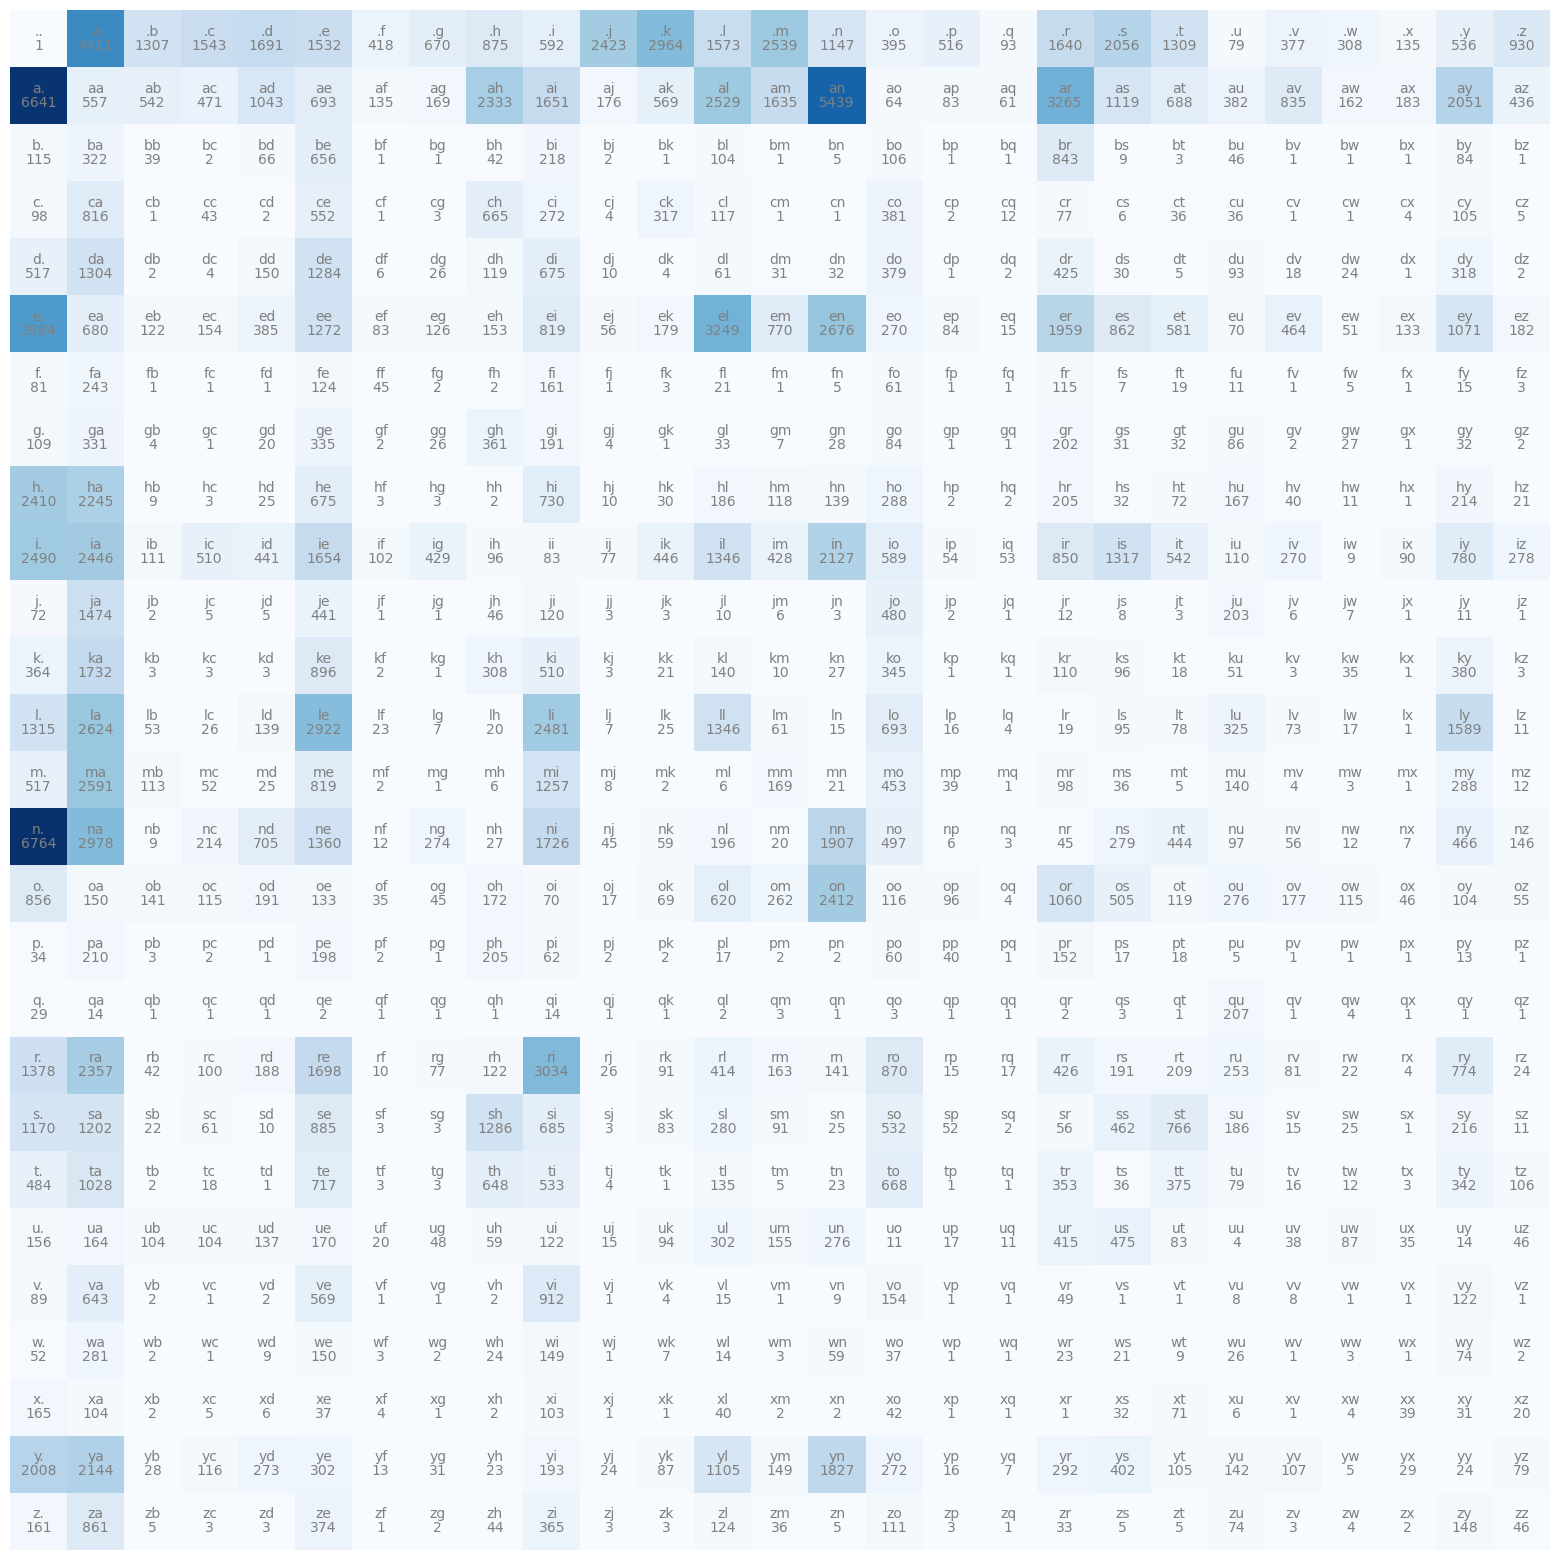

In [502]:
print("This figure represents the amount of times a specific two letter string is present in the input file.\nThe '.' character represents the start or end of a string")

plt.figure(figsize=(20,20))
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j,i, chstr, ha="center", va="bottom", color="grey")
        plt.text(j,i, countsArray[i,j].item(), ha="center", va="top", color="grey")
plt.axis("off")
plt.imshow(countsArray, cmap="Blues")

### Lets create a probability distribution of these 2 character strings

In [503]:
distributions = countsArray.float()
distributions /= distributions.sum(1, keepdim=True)

In [520]:
print("Generated names:\n")
g = torch.Generator().manual_seed(2147483647)


for i in range(10):
    out = []
    ix = 0
    while True:
        p = distributions[ix]
        ix = torch.multinomial(countsArray[ix].float(), num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print("".join(out))

Generated names:

cexze.
momasurailezitynn.
konimittain.
llayn.
ka.
da.
staiyaubrtthrigotai.
moliellavo.
ke.
teda.


In [505]:
loglikelihood = 0
n=0
for word in words:
    chs = ["."] + list(word) + ["."]
    for ch1, ch2 in zip(chs,chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = distributions[ix1, ix2]
        logprob = torch.log(prob)
        loglikelihood += logprob
        n+=1
        #print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print("Average loglikelihood: " + str(loglikelihood.item()/n))


Average loglikelihood: -2.4543562565199477


# Using ML to get the probability distributions

In [506]:
import torch.nn.functional as F

In [507]:
''' Create the training set '''
xs, ys = [], []

for w in words:
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs,chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
numberOfExamples = xs.nelement()


In [508]:
W = torch.randn((27,27), requires_grad=True)

In [509]:
''' Gradient descent '''
for k in range(100):

    # Forward pass
    logits = (xenc @ W)
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)
    xenc = F.one_hot(xs, num_classes=27).float()
    loss = -probs[torch.arange(numberOfExamples), ys].log().mean()

    # Backward pass
    W.grad = None
    loss.backward()
    W.data -= 50 * W.grad

    print(loss.item())

3.706714153289795
3.355560302734375
3.1461448669433594
3.0009114742279053
2.9035513401031494
2.8325281143188477
2.7792787551879883
2.7389838695526123
2.7077903747558594
2.6829776763916016
2.6627631187438965
2.645972967147827
2.631798267364502
2.619657039642334
2.6091203689575195
2.599869728088379
2.5916645526885986
2.5843207836151123
2.577699661254883
2.5716915130615234
2.566210985183716
2.5611889362335205
2.5565695762634277
2.552306652069092
2.54836106300354
2.54469895362854
2.541292190551758
2.5381147861480713
2.5351455211639404
2.5323646068573
2.529755115509033
2.527301549911499
2.524991035461426
2.522810697555542
2.520750045776367
2.5187995433807373
2.516950845718384
2.515195369720459
2.513526201248169
2.5119378566741943
2.5104236602783203
2.508979558944702
2.5075998306274414
2.5062804222106934
2.5050175189971924
2.5038082599639893
2.502647876739502
2.501534938812256
2.5004653930664062
2.4994378089904785
2.4984488487243652
2.4974966049194336
2.496579885482788
2.4956958293914795
2.4

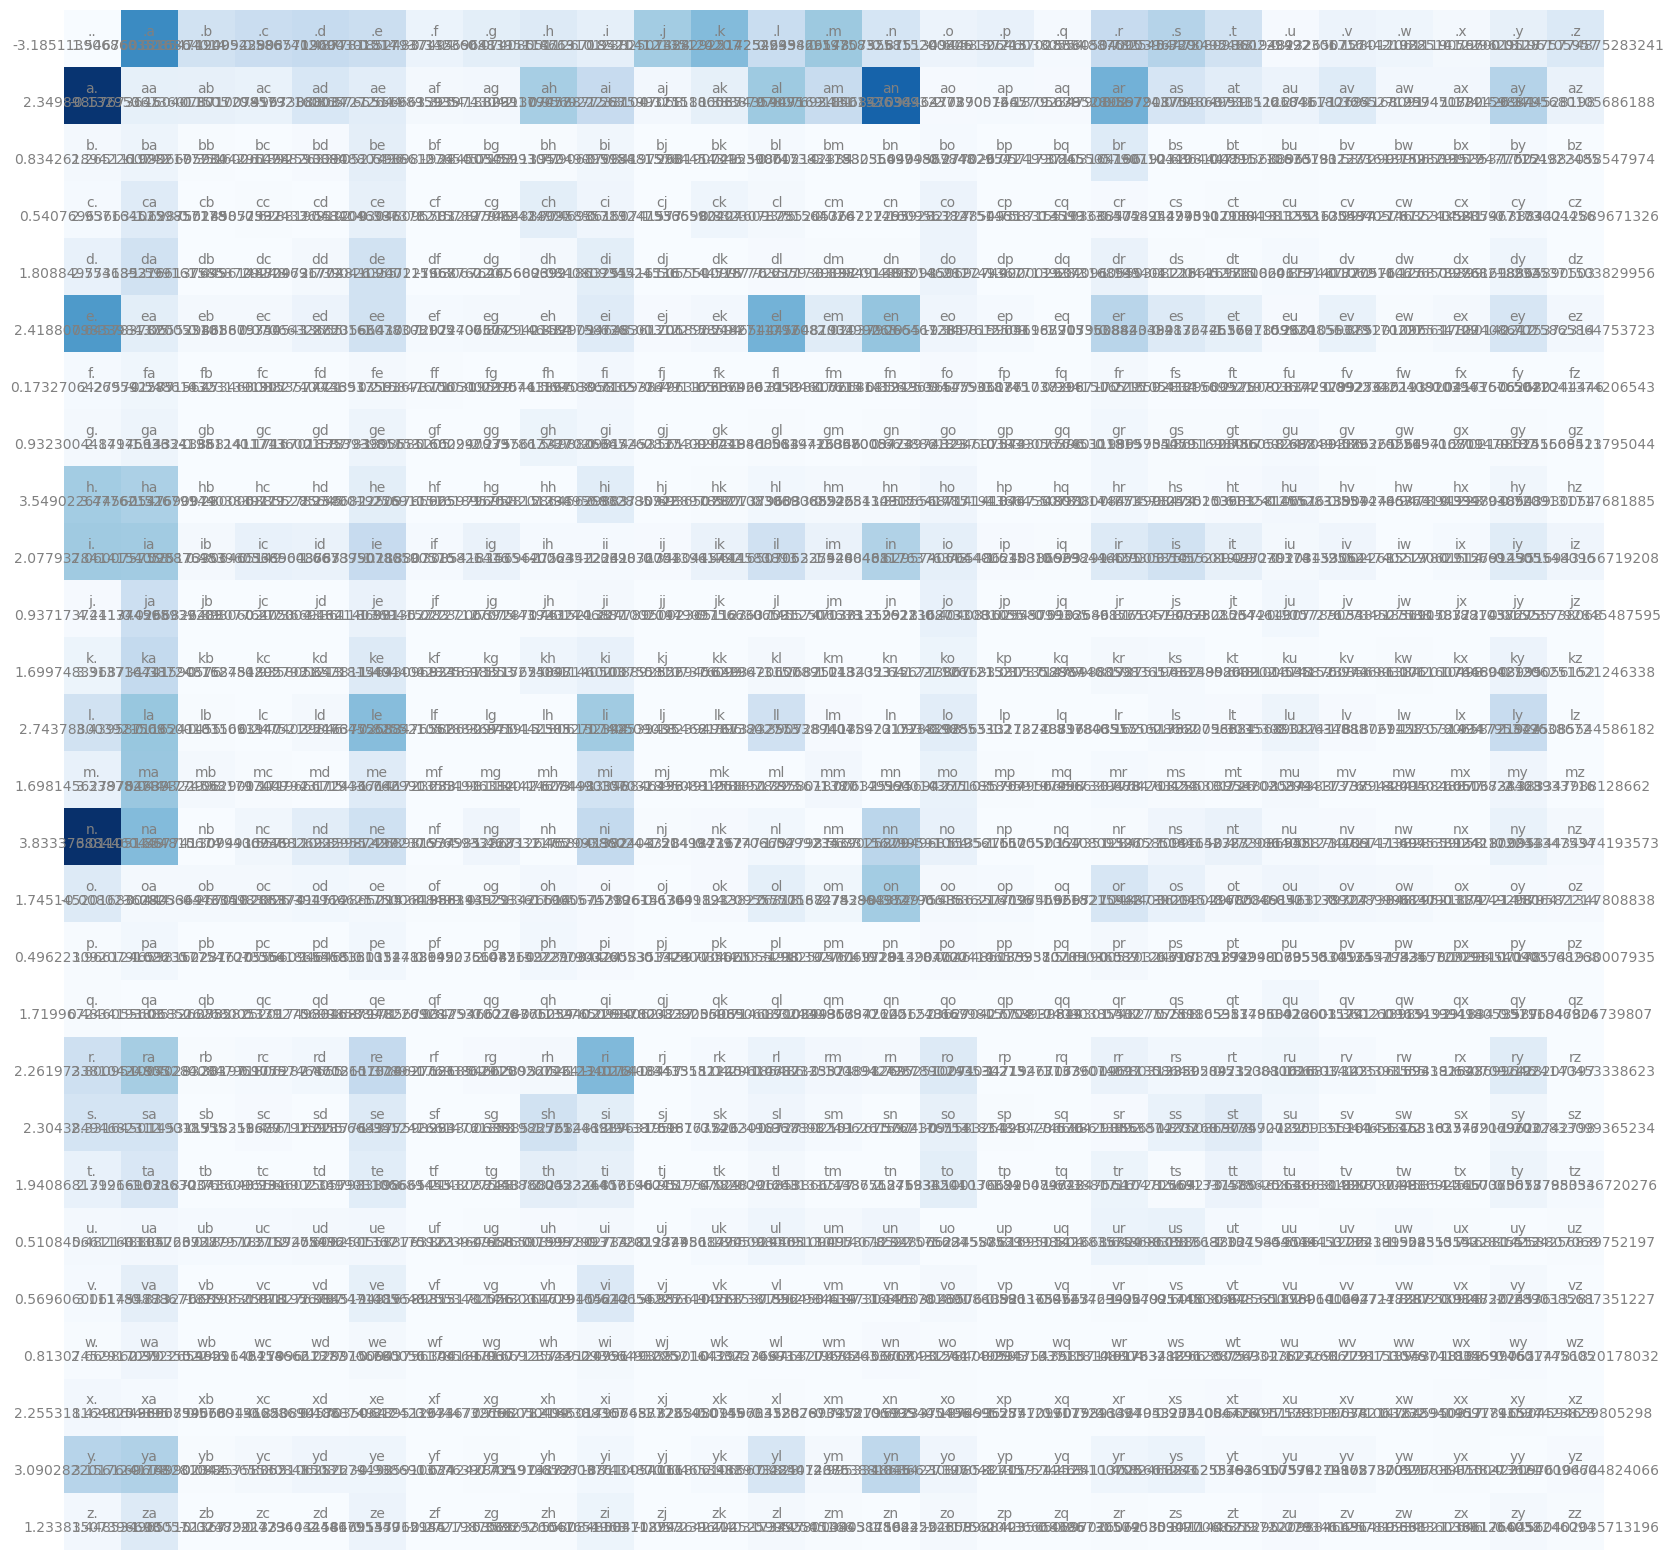

In [510]:
''' The probability distribution '''

plt.figure(figsize=(20,20))
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j,i, chstr, ha="center", va="bottom", color="grey")
        plt.text(j,i, W[i,j].item(), ha="center", va="top", color="grey")
plt.axis("off")
plt.imshow(countsArray, cmap="Blues")

In [521]:
''' Get generated names '''
g = torch.Generator().manual_seed(2147483647)

for i in range(10):

    out = []
    ix = 0
    while True:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc @ W 
        counts = logits.exp()
        p = counts / counts.sum(1, keepdim=True)

        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    
    print("".join(out))

cexze.
momasurailezityha.
konimittain.
llayn.
ka.
da.
staiyaubrtthrigotai.
moliellavo.
ke.
teda.
